# Super-resolution

In this example, we expand upon the basics of operator learning and
demonstrate the use of neural operators for super-resolution.

We will employ the FLAME dataset, a set of flow samples of resolution 32x32 that
should be up-sampled to 128x128. You can download the data set from
[Kaggle](https://www.kaggle.com/competitions/2023-flame-ai-challenge/data)
and put it into the `data/flame` directory to reproduce this example.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import pathlib
import matplotlib.pyplot as plt
from continuity.benchmarks.flame import FlameDataset
from continuity.operators import DeepONet
from continuity.trainer import Trainer
from continuity.trainer.callbacks import PrintTrainingLoss, LearningCurve

In [3]:
torch.manual_seed(1)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Flame Dataset

Continuity provides the `Flame` class (a special `OperatorDataset`) that reads
and exports samples from the FLAME data. The data set contains train/val splits
and has four channels `ux`, `uy`, `uz`, and `rho`. In this example,
we only use channel `ux` from the first four samples of the val split,
and we visualize the provided data using matplotlib.

In [4]:
N = 4
flame_dir = pathlib.Path.cwd().joinpath("..", "data", "flame")
flame = FlameDataset(flame_dir=flame_dir, size=N, split="val", channels=["ux"])

In [30]:
# Fallback if flame data is not available (e.g. in CI)
from continuity.operators.shape import OperatorShapes, TensorShape

flame_dir = pathlib.Path.cwd().joinpath("..", "data", "flame")
if not flame_dir.joinpath("flowfields").is_dir():
    N = 4
    class DummyFlame:
        x = torch.randn(N, 256, 2)
        u = torch.randn(N, 256, 1)
        y = torch.randn(N, 16384, 2)
        v = torch.randn(N, 16384, 1)

        shapes = OperatorShapes(
            x=TensorShape(256, 2),
            u=TensorShape(256, 1),
            y=TensorShape(16384, 2),
            v=TensorShape(16384, 1),
        )

        def __getitem__(self, i):
            return self.x[i], self.u[i], self.y[i], self.v[i]
        
        def __len__(self):
            return N

    flame = DummyFlame()

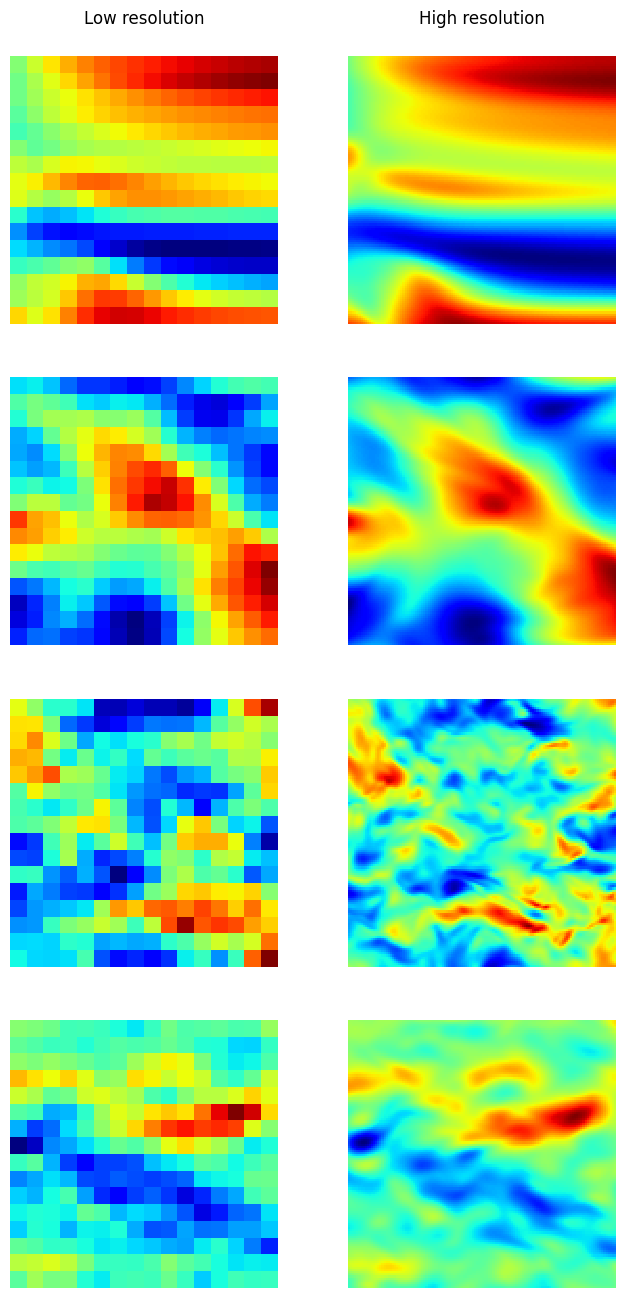

In [31]:
fig, ax = plt.subplots(N, 2, figsize=(8, 4 * N))
for i in range(N):
    u = flame[i][1]
    um = u.reshape((16, 16)).flip(1).T.cpu()
    ms = ax[i][0].matshow(um, cmap="jet")
    ax[i][0].axis('off')
    v = flame[i][3]
    vm = v.reshape((128, 128)).flip(1).T.cpu()
    ms = ax[i][1].matshow(vm, cmap="jet")
    ax[i][1].axis('off')
ax[0][0].set_title("Low resolution")
_ = ax[0][1].set_title("High resolution")

## Operator

We define a `DeepONet` to map the low-resolution data to a continuous function.
Note that we increase the expressivity of the trunk network by increasing the
width and depth.

In [32]:
operator = DeepONet(shapes=flame.shapes, trunk_width=128, trunk_depth=64)

## Training

With an `OperatorDataset` at hand, training is straightforward using the `Trainer.fit` method.
Here, we add the `LearningCurve` callback to monitor the training loss.

Model parameters: 1069840
Device: mps
Epoch 3000:  loss/train = 5.1067e-03  (0.434 s/epoch)


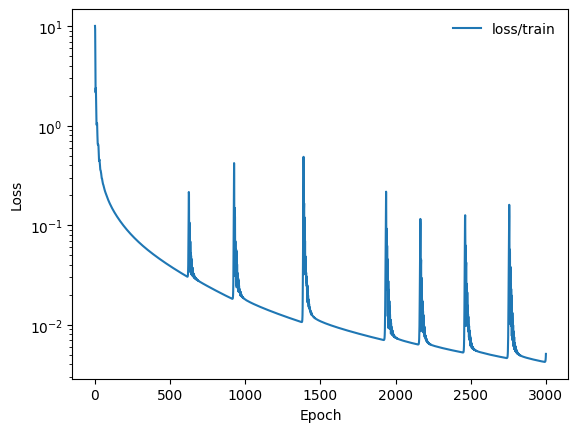

In [33]:
trainer = Trainer(operator, lr=1e-4)
trainer.fit(flame, epochs=3000, callbacks=[LearningCurve()])

## Evaluation

As we can evaluate the trained operator at arbitrary
positions, we can plot the mapped function on a fine mesh
with 128 positions (or any other resolution), aka super-resolution!

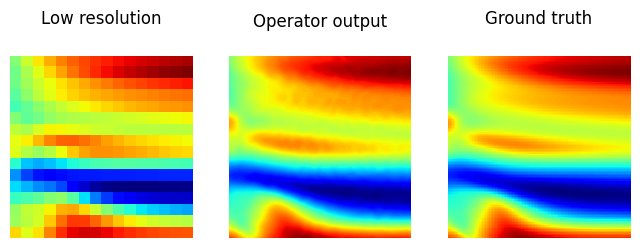

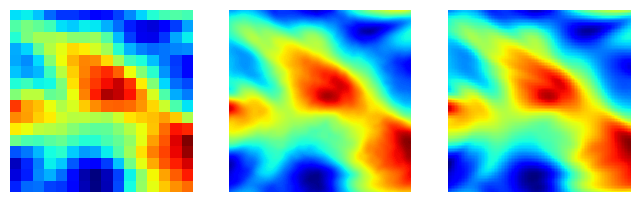

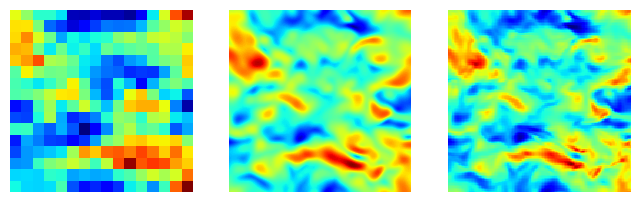

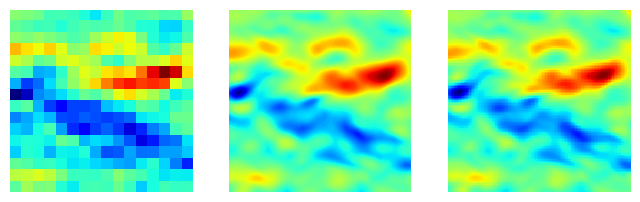

In [34]:
a = torch.linspace(-1, 1, 128)
X, Y = torch.meshgrid(a, a, indexing='ij')
yy = torch.stack([X.flatten(), Y.flatten()], dim=1)

for i in range(N):
    x, u, _, v = flame[i]
    vv = operator(x.unsqueeze(0), u.unsqueeze(0), yy.unsqueeze(0)).squeeze(0)
    vv = vv.detach().cpu().reshape(X.shape)

    _, ax = plt.subplots(1, 3, figsize=(8, 4))
    um = u.reshape((16, 16)).flip(1).T.cpu()
    vm = v.reshape((128, 128)).flip(1).T.cpu()
    ax[0].matshow(um, cmap="jet")
    ax[1].contourf(X, Y, vv, levels=200, cmap='jet')
    ax[2].matshow(vm, cmap='jet')
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[2].set_aspect('equal')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    if i == 0:
        ax[0].set_title("Low resolution")
        ax[1].set_title("Operator output\n")
        ax[2].set_title("Ground truth")
    plt.show()